In [1]:
import ROOT as r 
import math
import numpy as np 
#g-2 Blinding Software
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import multiprocessing

# this will contain modules which compute the double/triple pileup correction and apply it to an input histogram
# using Aarons bootstrapped pileup method

class PileupCorrector:
    '''
        This class will take as input a 2D histogram of Energy vs. time and will perform a pileup correction on it
        Inputs:
            h (TH2) : histogram to be pileup corrected
            name (str): name of the histogram
            iteration (int): how many times has this gone through the correction algorithm
    '''

    fitOptions = "R"

    def __init__(self, h, name, iteration = 0, deltat = 2, verbosity = 0):
        self.h = h.Clone("N_initial_"+str(iteration)+"_"+name)
        self.h_y = h.ProjectionY().Clone("h_y")
        self.name = name
        self.iteration = iteration 
        self.deltat = deltat
        self.verbosity = 0

        self.rhoDouble = None 

    ''' Allows us to skip the step of calculating rho_double if we have one already saved '''
    def SetRhoDouble(self, h):
        self.rhoDouble = h.Clone("h_rhoDouble_"+str(self.iteration)+"_"+self.name)
        self.rhoDouble.SetDirectory(0)

    ''' first define a function which takes a histogram and returns the quantity described in Eqn. 6.12 '''
    def rhoDoublePulse( self, E, t ):
        timeBin = self.h.GetXaxis().FindBin( t )
        h2 = self.h.ProjectionY("h2", timeBin, timeBin)
        
        Nbins = h2.GetNbinsX() 
        #Emin = h2.GetBinCenter(1) - h2.GetBinWidth(1)/2.0
        #Emax = h2.GetBinCenter(Nbins) + h2.GetBinWidth(Nbins)/2.0
            
        rho = 0
        for bin in range(Nbins):
            E2 = h2.GetBinCenter(bin)
            if( E < E2 ):
                r1 = 0
            else:
                bin2 = h2.FindBin( E - E2 )
                r1 = h2.GetBinContent(bin2)
                
            r2 = h2.GetBinContent(bin)
            rho += r1*r2
        
        return rho

    ''' If not set, compute rho_double '''
    def rhoDoubleIterable(self, binx):
            print(binx)
            if(self.verbosity > 0):
                print("    ", binx,"/",nBinsX+1)
            for biny in range(1,nBinsY+1):
                Ei = self.rhoDouble.GetYaxis().GetBinCenter(biny)
                ti = self.rhoDouble.GetXaxis().GetBinCenter(binx)
                rhoi = self.rhoDoublePulse( Ei, ti )
                #print(rhoi)
                self.rhoDouble.SetBinContent(binx,biny,rhoi)
    
    def ComputeRhoDouble(self):
        self.rhoDouble = self.h.Clone("h_rhoDouble_"+str(self.iteration)+"_"+self.name)
        self.rhoDouble.Reset()

        nBinsX = self.rhoDouble.GetXaxis().GetNbins()
        nBinsY = self.rhoDouble.GetYaxis().GetNbins()
        p = multiprocessing.Pool(processes = multiprocessing.cpu_count()-1)

        print("Computing rho_double histogram")
        for binx in range(1,nBinsX+1):
            print("starting async", binx)
            p.apply_async(self.rhoDoubleIterable, [binx])
        p.close()
        p.join()
        print("All done")
    
    ''' and now to calculate the double pileup bin by bin '''
    def rhoDoublePileup(self, E, t):
        histBinEtDouble = self.rhoDouble.FindBin(t,E)
        histBinEtN = self.h.FindBin(t,E)
        histBintN = self.h.GetXaxis().FindBin(t)
        histBinEN = self.h.GetYaxis().FindBin(E)
        hi = self.h.ProjectionY("", histBintN, histBintN).Clone()
        integralN = hi.Integral(hi.FindBin(histBinEN),-1)
        rho = self.deltat * ( self.rhoDouble.GetBinContent(histBinEtDouble) - 2*self.h.GetBinContent(histBinEtN)*integralN )
        
        return rho

    ''' and now actually compute the double correction '''
    def ComputeDoubleCorrection(self):
        if(self.rhoDouble == None):
            print("rho_double is not set. Computing")
            self.ComputeRhoDouble()

        self.doublePileup = self.h.Clone("DoublePileup_"+str(self.iteration)+"_"+self.name)
        self.doublePileup.Reset()
        self.doublePileup.SetTitle("Double Pileup [Unscaled]")

        nBinsX = self.doublePileup.GetXaxis().GetNbins()
        nBinsY = self.doublePileup.GetYaxis().GetNbins()

        print("Computing double pileup correction")
        for binx in range(1,nBinsX+1):
            #if binx > 100:
            #    break
            if(self.verbosity > 0):
                print("    ", binx,"/",nBinsX+1)
            for biny in range(1,nBinsY+1):
                Ei = self.doublePileup.GetYaxis().GetBinCenter(biny)
                ti = self.doublePileup.GetXaxis().GetBinCenter(binx)
                rhoi = self.rhoDoublePileup(Ei, ti)
                #print(rhoi)
                self.doublePileup.SetBinContent(binx,biny,rhoi)
        self.doublePileupY = self.doublePileup.ProjectionY().Clone("doublePileupY")

    ''' fit histogram using method here https://root.cern.ch/root/html/tutorials/fit/fithist.C.html '''
    def fitHistDouble(self, x, p):
        rawHist = self.doublePileupY
        scaleFactor = p[0]
        y = rawHist.GetBinContent( rawHist.FindBin(x[0]) ) * scaleFactor
        return y

    ''' here we fit only the double pileup and apply the correction factor to a clone of self.h '''
    def FitDoublePileupAndApplyCorrection(self):
        doublePileupFit = r.TF1("doublePileupFit", self.fitHistDouble, 3500, 6000, 1)
        doublePileupFit.SetParameter(0,1)
        self.h_y.Fit(doublePileupFit, self.fitOptions)

        self.doublePileupOnlyScaleFactor = doublePileupFit.GetParameter(0)
        self.h_doublePileupCorrected = self.h.Clone("h_doublePileupCorrected")
        ding = self.doublePileup#.Clone("ding")
        ding.Scale( self.doublePileupOnlyScaleFactor )
        self.h_doublePileupCorrected.Add( ding , -1)
        ding.Scale( 1/(self.doublePileupOnlyScaleFactor) )

    def rhoTriplePileup(self, E, t):
        timeBinN = self.h.GetXaxis().FindBin( t )
        energySliceN = self.h.ProjectionY("", timeBinN, timeBinN).Clone()
        
        timeBinRho = self.rhoDouble.GetXaxis().FindBin( t )
        energySliceRho = self.rhoDouble.ProjectionY("", timeBinRho, timeBinRho).Clone()
        
        int1 = 0
        for bin1 in range( energySliceRho.GetNbinsX() ):
            Ed = energySliceRho.GetBinContent( bin1 )
            if( Ed > E ):
                int1 += 0
            else:
                rho1 = energySliceN.GetBinContent( energySliceN.GetXaxis().FindBin( E - Ed ) )
                rho2 = energySliceRho.GetBinContent( energySliceRho.GetXaxis().FindBin(Ed) )
                int1 += rho1*rho2
                #print(rho1,rho2)
            #print(int1)
        int2 = energySliceN.Integral()
        int3 = (int2)**2
        
        rhoDoubleEt = self.rhoDouble.GetBinContent( self.rhoDouble.GetXaxis().FindBin(t), self.rhoDouble.GetYaxis().FindBin(E) )
        rhoEt = self.h.GetBinContent( self.h.GetXaxis().FindBin(t), self.h.GetYaxis().FindBin(E) )
        
        #print("***************************************")
        #print(int1,int2,int3)
        #print(rhoDoubleEt, rhoEt)
        #print(((self.deltat)**2) * ( int1 ) )
        #print( int1 , - 3*rhoDoubleEt*int2 , 3*rhoEt*int3 )
        
        return ((self.deltat)**2) * ( int1 - 3*rhoDoubleEt*int2 + 3*rhoEt*int3 )

    def ComputeTripleCorrection(self):
        self.triplePileup = self.h.Clone("triplePileup")
        self.triplePileup.Reset()
        nBinsX = self.triplePileup.GetXaxis().GetNbins()
        nBinsY = self.triplePileup.GetYaxis().GetNbins()

        print("Starting triple correction")
        for binx in range(1,nBinsX+1):
            #if binx > 10:
            #    break
            if(self.verbosity > 0):
                print(binx,"/",nBinsX+1)
            for biny in range(1,nBinsY+1):
                Ei = self.triplePileup.GetYaxis().GetBinCenter(biny)
                ti = self.triplePileup.GetXaxis().GetBinCenter(binx)
                rhoi = self.rhoTriplePileup(Ei, ti)
                #print(rhoi)
                self.triplePileup.SetBinContent(binx,biny,rhoi)

        self.triplePileupY = self.triplePileup.ProjectionY().Clone("triplePileupY")

    def fitHistTriple(self, x, p):
        rawHistDouble = self.doublePileupY
        rawHistTriple = self.triplePileupY
        scaleFactorDouble = p[0]
        scaleFactorTriple = p[1]
        y = ( rawHistDouble.GetBinContent( rawHistDouble.FindBin(x[0]) ) * scaleFactorDouble 
            + rawHistTriple.GetBinContent( rawHistTriple.FindBin(x[0]) ) * scaleFactorTriple )
        return y

    ''' here we fit the double and triple pileup and apply the correction factor to a clone of self.h '''
    def FitTriplePileupAndApplyCorrection(self):
        triplePileupFit = r.TF1("doublePileupFit", self.fitHistTriple, 3500, 6000, 2)
        triplePileupFit.SetParameters(1,1)
        for i in range(2):
            self.h_y.Fit(triplePileupFit, self.fitOptions)

        self.pileupScaleFactors = [ triplePileupFit.GetParameter(i) for i in range(2) ]
        self.h_pileupCorrected = self.h.Clone("h_pileupCorrected")
        ding = self.doublePileup#.Clone("ding")
        ding.Scale( self.pileupScaleFactors[0] )
        self.h_pileupCorrected.Add( ding , -1)
        ding.Scale( 1/( self.pileupScaleFactors[0] ) )

        ding = self.triplePileup#.Clone("ding")
        ding.Scale( self.pileupScaleFactors[1] )
        self.h_pileupCorrected.Add( ding , -1)
        ding.Scale( 1/(self.pileupScaleFactors[1] ) )

    def FullChain(self):
        print("Running full pileup correction on input histogram.")
        self.ComputeRhoDouble()
        self.ComputeDoubleCorrection()
        self.FitDoublePileupAndApplyCorrection()
        self.ComputeTripleCorrection()
        self.FitTriplePileupAndApplyCorrection()
        print("Correction completed! Final histogram stored in h_pileupCorrected")

Welcome to JupyROOT 6.12/06


In [2]:
f = r.TFile("../truncationTest/data/results_1MissingFile_FullVsTrunc.root")

In [3]:
clusters = f.Get("clustersAndCoincidences").Get("clusters").Clone("clusters")

In [4]:
fileString = "_1MissingFile"
print("Creating files with:", fileString, "suffix")

Creating files with: _1MissingFile suffix


In [ ]:
Ninitial = clusters.Project3D("yx").Clone()
Ninitial.Rebin2D(10,10)

<ROOT.TH2D object ("clusters_yx") at 0x7fffbeb3cde0>

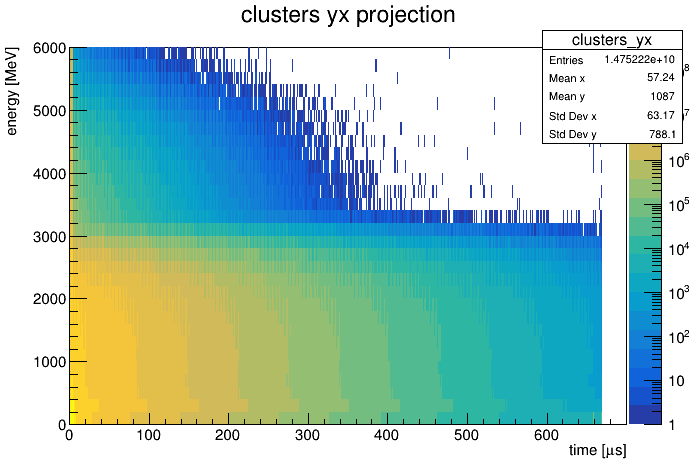

In [ ]:
c = r.TCanvas()
Ninitial.Draw("colz")
c.SetLogz()
c.Draw()

In [ ]:
corrector = PileupCorrector(Ninitial, "Test", 0, 2)

In [ ]:
import time
start = time.time()
corrector.fitOptions = "REMB"
corrector.FullChain()
end = time.time()

Running full pileup correction on input histogram.


In [ ]:
deltaT = end - start